# Model Structure: Modified SEResNet152 with DistilBERT Captioning System(Both Transfer Learned).

# Import Dependencies

In [1]:
%%capture
import PIL

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import tqdm.notebook as tqdm
from sklearn.model_selection import train_test_split

import random
import copy
import cv2
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

!pip install livelossplot
import livelossplot

!pip install timm
import timm

!pip install transformers
import transformers

!pip install kaggle
import nltk 
nltk.download('punkt')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
!mkdir /root/.kaggle/
!cp -f ./kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


Load in the Dataset(FlicKR)

In [3]:
%%capture
#!kaggle datasets download -d hsankesara/flickr-image-dataset
#!unzip -a ./flickr-image-dataset.zip
#!rm -f flickr-image-dataset.zip

In [4]:
# Extract Unique Images(So dataset is only 30K images long)
images_dataframe = pd.read_csv("./flickr30k_images/results.csv", error_bad_lines=False, sep = "|", index_col = 'image_name')
images_dataframe = images_dataframe.iloc[images_dataframe[' comment_number'].values == ' 0']

Helpers for Reproducibility:

In [5]:
import os
import random
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    numpy.random.seed(worker_seed)
    random.seed(worker_seed)

# Custom Dataloader

In [7]:
# HYPER PARAMETERS 
BASE_IMAGE_PATH = "./flickr30k_images/flickr30k_images/"
BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
TRAIN_SIZE = 0.9995

Transforms

In [8]:
# Transforms Used
TRAIN_TRANSFORMS = transforms.Compose([
  transforms.RandomGrayscale(),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(10),
  transforms.ColorJitter(),
  transforms.RandomRotation(15),
  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])
TEST_TRANSFORMS = transforms.Compose([
  transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [9]:
class ImageCaptioningDataset(torch.utils.data.Dataset):
  def __init__(self, transforms, base_path, dataframe, device):
    self.dataframe = dataframe
    self.transforms = transforms 
    self.base_path = base_path
    self.device = device
  def __len__(self):
    return len(self.dataframe)
  def __getitem__(self, idx):
    index = self.dataframe.index[idx]
    caption = str.strip(self.dataframe.iloc[idx][1])[:-2]
    lower_caption = str.lower(caption)
    # Load in Image
    image_path = self.base_path + index
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = torch.tensor(image, device = self.device).to(torch.float32) / 255.0
    image = image.transpose(1, 2).transpose(0, 1)
    image = self.transforms(image)
    
    return image, caption

In [10]:
Train_dataframe, Val_dataframe = train_test_split(images_dataframe, train_size = TRAIN_SIZE, test_size = 1 - TRAIN_SIZE, random_state = 42)

In [11]:
Train_Dataset = ImageCaptioningDataset(TRAIN_TRANSFORMS, BASE_IMAGE_PATH, Train_dataframe, device)
Val_Dataset = ImageCaptioningDataset(TEST_TRANSFORMS, BASE_IMAGE_PATH, Val_dataframe, device)

In [12]:
def custom_collate(vals):
  images = []
  labels = []
  for val in vals:
    images += [val[0]]
    labels += [val[1]]
  return images, labels

Train/Val Split

In [13]:
TrainDataloader = torch.utils.data.DataLoader(Train_Dataset, batch_size = BATCH_SIZE, shuffle = True, worker_init_fn = seed_worker, collate_fn = custom_collate)
ValDataloader = torch.utils.data.DataLoader(Val_Dataset, batch_size = TEST_BATCH_SIZE, collate_fn= custom_collate)

# Image Encoding

Custom Resizer: Using a Bilinear Model to scale down images to 224 x 224

Using a CNN to resize down images: as proposed recently.

In [14]:
class ConvBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size, padding, groups):
    super().__init__()
    self.conv = nn.Conv2d(in_features, out_features, kernel_size = kernel_size, padding = padding, groups = groups)
    self.bn = nn.BatchNorm2d(out_features)
    self.act1 = nn.SiLU(inplace = True)
  def forward(self, x):
    return self.bn(self.act1(self.conv(x)))

In [15]:
class DownSampleConvBlock(nn.Module):
  def __init__(self, in_features, out_features, kernel_size, padding, groups, stride):
    super().__init__()
    self.conv = nn.Conv2d(in_features, out_features, kernel_size, stride, padding = padding, groups = groups)
    self.bn = nn.BatchNorm2d(out_features)
    self.act1 = nn.SiLU(inplace = True)
  def forward(self, x):
    return self.bn(self.act1(self.conv(x)))

In [16]:
class RegularSE(nn.Module):
  '''
  Regular Squeeze and Excitation Block 
  '''
  def __init__(self, in_dim, inner_dim):
    super().__init__()
    self.in_dim = in_dim
    self.inner_dim = inner_dim
    self.Squeeze = nn.Linear(self.in_dim, self.inner_dim)
    self.SiLU = nn.SiLU(inplace = True)
    self.Excite = nn.Linear(self.inner_dim, self.in_dim)
  def forward(self, x):
    '''
    Performs Channel-Wise Attention using Squeeze Excite Blocks
    '''
    avg_pool = torch.mean(x, dim = -1)
    avg_pool = torch.mean(avg_pool, dim = -1) 
    squeeze = self.SiLU(self.Squeeze(avg_pool))
    excite = torch.sigmoid(self.Excite(squeeze)).unsqueeze(-1).unsqueeze(-1)
    return excite * x 


In [17]:
class ResBottleNeck(nn.Module):
  def __init__(self, in_features, inner_features, device):
    super().__init__()
    self.device = device
    self.in_features = in_features
    self.inner_features = inner_features
    
    self.squeeze = ConvBlock(self.in_features, self.inner_features, 1, 0, 1)
    self.process = ConvBlock(self.inner_features, self.inner_features, 3, 1, self.inner_features)
    self.SE = RegularSE(self.inner_features, self.inner_features // 4)
    self.expand = ConvBlock(self.inner_features, self.in_features, 1, 0, 1)
    self.gamma = nn.Parameter(torch.zeros(1, device = self.device))
  def forward(self, x):
    '''
    x: Tensor(B, C, H, W)
    '''
    squeeze = self.squeeze(x)
    process= self.process(squeeze)
    SE = self.SE(process)
    expand = self.expand(SE) 
    return expand * self.gamma + x


In [18]:
class CNNDownSampler(nn.Module):
  '''
  Leverages Bilinear interpolation and a CNN to resize and enhance image features
  '''
  def __init__(self, out_size, device):
    super().__init__()
    self.device = device
    self.out_size = out_size
    self.initial_processing = nn.Sequential(*[
      ConvBlock(3, 16, 7, 3, 1),
      ResBottleNeck(16, 4, self.device)
    ])
    self.num_res = 2
    self.middle_processing = nn.Sequential(*[
      ResBottleNeck(16, 4, self.device) for i in range(self.num_res) 
    ])
    
    self.proj = ConvBlock(16, 3, 1, 0, 1)
    self.gamma = nn.Parameter(torch.zeros((1), device = self.device))
  def forward(self, x):
    '''
    x: Tensor(3, H, W)
    H and W can be anything:
    output: Tensor(B, 3, out_size, out_size), enhanced resized image features
    '''
    x = x.unsqueeze(0) # (1, 3, H, W)
    # Interpolate to desired size(One pathway)
    resized_base = F.interpolate(x, size = (self.out_size, self.out_size), mode= 'bilinear')
    # Use Convolutions
    initial_processed = self.initial_processing(x) # (B, 16, H, W) 
    # Interpolate again
    resized_processed = F.interpolate(initial_processed, (self.out_size, self.out_size), mode = 'bilinear')
    middle_processed = self.middle_processing(resized_processed)
    proj = self.proj(middle_processed)
    return proj * self.gamma + resized_base

In [19]:
class DownSampler(nn.Module):
  def __init__(self, out_size, device):
    super().__init__()
    self.out_size = out_size
    self.device = device
    self.downsampler = CNNDownSampler(self.out_size, self.device)
  def forward(self, images):
    '''
    Resizes and processes a batch
    '''
    resized_images = []
    for image in images:
      resized_images += [torch.squeeze(self.downsampler(image))]
    return torch.stack(resized_images)

In [20]:
class InvertedResidualBlock(nn.Module):
  def __init__(self, in_features, inner_features, device):
    super().__init__()
    self.device = device
    self.in_features = in_features
    self.inner_features = inner_features
    self.squeeze = ConvBlock(self.in_features, self.inner_features, 1, 0, 1)
    self.depthwise = ConvBlock(self.inner_features, self.inner_features, 3, 1, self.inner_features)
    self.SE = RegularSE(self.inner_features, self.in_features // 16)
    self.expand = ConvBlock(self.inner_features, self.in_features, 1, 0, 1)
    self.gamma = nn.Parameter(torch.zeros((1), device = self.device))
  def forward(self, x):
    squeeze = self.squeeze(x)
    depthwise = self.depthwise(squeeze)
    SE = self.SE(depthwise)
    expand = self.expand(SE)
    return expand * self.gamma + x

EfficientNetb0 Transfer Learned:

In [21]:
class EfficientNet(nn.Module):
  '''
  Modified EfficientNetb0
  '''
  def freeze(self, layer):
    for parameter in layer.parameters():
      parameter.requires_grad = False
  def unfreeze(self, layer):
    for parameter in layer.parameters():
      parameter.requires_grad = True
  def __init__(self, out_features, device):
    super().__init__()
    self.out_features = out_features
    self.device = device
    # Download Pretrained model and Weights
    self.model = timm.create_model("efficientnet_b0", pretrained = True)
    # Extract Layers
    self.conv1 = self.model.conv_stem
    self.bn1 = self.model.bn1
    self.act1 = self.model.act1
    # Pretrained Blocks
    self.block0 = self.model.blocks[0]
    self.block1 = self.model.blocks[1]
    self.block2 = self.model.blocks[2] # (B, 40, 32, 32)
    self.block3 = self.model.blocks[3]
    self.block4 = self.model.blocks[4] # (B, 112, 16, 16)
    self.block5 = self.model.blocks[5]
    self.block6 = self.model.blocks[6] # (B, 320, 8, 8)
    # Freeze a Few Initial Layers
    self.freeze(self.block0)
    self.freeze(self.block1)
    self.freeze(self.bn1)
    self.freeze(self.conv1)
    # Custom Layers
    self.Attention1 = RegularSE(40, 8)
    self.Attention2 = RegularSE(112, 32)
    self.Attention3 = RegularSE(320, 64)

    self.features_extract =nn.Identity() #nn.Sequential(*
    #  [DownSampleConvBlock(320, 320, 5, 2, 320, 2), ConvBlock(320, 512, 1, 0, 1)] + 
    #  [InvertedResidualBlock(512, 1024, self.device) for i in range(5)])
    self.proj = ConvBlock(320, self.out_features, 1, 0, 1) # Not Enough for Compute
  def forward(self, x):
    B, _, _, _ = x.shape
    conv1 = self.bn1(self.act1(self.conv1(x))) # (B, 32, 128, 128)
    
    block0 = self.block0(conv1)
    block1 = self.block1(block0)
    block2 = self.block2(block1)
    attention1 = self.Attention1(block2)
    block3 = self.block3(attention1)
    block4 = self.block4(block3)
    attention2 = self.Attention2(block4)
    block5 = self.block5(attention2)
    block6 = self.block6(block5)
    attention3 = self.Attention3(block6)
    
    extract_features = self.proj(self.features_extract(attention3)) # (B, 768, 4, 4)
    return extract_features.view(B, self.out_features, -1).transpose(1, 2) # (B, 16, 768)

In [22]:
class ImageEncoder(nn.Module):
  def __init__(self, in_dim, out_size, device):
    super().__init__()
    self.device = device
    self.in_dim = in_dim
    self.out_size = out_size
    self.downsampler = DownSampler(self.out_size, self.device)
    self.encoder = EfficientNet(self.in_dim, self.device)
  def forward(self, images):
    downsized_images = self.downsampler(images) # (B, 3, out_size, out_size)
    encoded = self.encoder(downsized_images)
    return encoded

# Custom Transformer(QANET)

In [23]:
class EncoderDecoderAttention(nn.Module):
  def __init__(self, in_features, inner_features, num_heads):
    super().__init__()
    self.in_features = in_features
    self.inner_features = inner_features
    self.num_heads = num_heads

    self.K = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.V = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.Q = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.Linear = nn.Linear(self.inner_features * self.num_heads, self.in_features)
  def forward(self, encoder, decoder):
    '''
    Encoder: Tensor(B, L_enc, C)
    Decoder: Tensor(B, L_dec, C)
    '''    
    B, L_enc, _ = encoder.shape
    B, L_dec, _ = decoder.shape 
    Keys = self.K(encoder)
    Values = self.V(encoder) # (B, L_enc, HI)
    Queries = self.Q(decoder) # (B, L_dec, HI)

    Keys = Keys.reshape(B, L_enc, self.num_heads, self.inner_features)
    Values = Values.reshape(B, L_enc, self.num_heads, self.inner_features) 
    Queries = Queries.reshape(B, L_dec, self.num_heads, self.inner_features)

    Keys = Keys.transpose(1, 2)
    Values = Values.transpose(1, 2)
    Queries = Queries.transpose(1, 2)

    Keys = Keys.reshape(B * self.num_heads, L_enc, self.inner_features)
    Values = Values.reshape(B * self.num_heads, L_enc, self.inner_features)
    Queries = Queries.reshape(B * self.num_heads, L_dec, self.inner_features)

    att_mat = F.softmax(torch.bmm(Keys, Queries.transpose(1, 2)) / math.sqrt(self.inner_features)) # (B, L_enc, L_dec)
    att_scores = torch.bmm(Values.transpose(1, 2), att_mat) # (B, L_dec, I)
    att_scores = att_scores.reshape(B, self.num_heads, L_dec, self.inner_features)
    att_scores = att_scores.transpose(1, 2)
    att_scores = att_scores.reshape(B, L_dec, -1)
    return self.Linear(att_scores)

In [24]:
class MultiHeadAttention(nn.Module):
  '''
  Computes MultiHeadAttention
  '''
  def __init__(self, in_features, inner_features, num_heads):
    super().__init__()
    self.in_features = in_features
    self.inner_features = inner_features
    self.num_heads = num_heads
    
    self.K = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.V = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.Q = nn.Linear(self.in_features, self.inner_features * self.num_heads)
    self.Linear = nn.Linear(self.inner_features * self.num_heads, self.in_features)
  def forward(self, x):
    '''
    x: Tensor(B, L, C)
    '''
    B, L, _ = x.shape
    Keys = self.K(x) # (B, L, HI)
    Values = self.V(x)
    Queries = self.Q(x) # (B, L, HI)

    Keys = Keys.reshape(B, L, self.num_heads, self.inner_features)
    Values = Values.reshape(B, L, self.num_heads, self.inner_features)
    Queries = Queries.reshape(B, L, self.num_heads, self.inner_features)

    Keys = Keys.transpose(1, 2) 
    Values = Values.transpose(1, 2)
    Queries = Queries.transpose(1, 2)

    Keys = Keys.reshape(B * self.num_heads, L, self.inner_features)
    Values = Values.reshape(B * self.num_heads, L, self.inner_features)
    Queries = Queries.reshape(B * self.num_heads, L, self.inner_features)

    att_mat = F.softmax(torch.bmm(Keys, Values.transpose(1, 2)) / math.sqrt(self.inner_features))
    att_scores = torch.bmm(att_mat, Queries) # (BH, L, I)

    att_scores = att_scores.reshape(B, self.num_heads, L, self.inner_features)
    att_scores = att_scores.transpose(1, 2)
    att_scores = att_scores.reshape(B, L, -1)
    return self.Linear(att_scores)

In [25]:
class QAEncoder(nn.Module):
  '''
  One QA Net Encoder Module
  '''
  def __init__(self, in_dim, inner_dim, num_heads, device):
    super().__init__()
    self.device = device
    self.in_dim = in_dim
    self.inner_dim = inner_dim
    self.num_heads = num_heads

    self.MAH = MultiHeadAttention(self.in_dim, self.inner_dim, self.num_heads)
    self.MAHNorm = nn.GroupNorm(1, self.in_dim) # Equivalent to LayerNorm

    self.Linear = nn.Linear(self.in_dim, self.in_dim)
    self.LinearNorm = nn.GroupNorm(1, self.in_dim)
  
  def forward(self, x):
    '''
    x: Tensor(B, L, C)
    '''
    pos_enc = self.add_pos_enc(x)

    attended = self.MAH(self.MAHNorm(pos_enc.transpose(1, 2)).transpose(1, 2)) + pos_enc

    linear = self.Linear(self.LinearNorm(attended.transpose(1, 2)).transpose(1, 2)) + attended
    return linear
  def add_pos_enc(self, x):
    '''
    Inserts positional encodings into the features(sinusoidal functions)
    x: Tensor(B, L, C)
    '''
    B, L, C = x.shape
    pos_enc = torch.zeros((L, C), device = self.device) 
    for pos in range(L):
      for i in range(0, C, 2):
        pos_enc[pos,i] = math.sin(pos / 10000 ** (2 * i / self.in_dim))
        pos_enc[pos, i + 1] = math.cos(pos / 10000 ** (2 * (i + 1) / self.in_dim))
    batched_pos= []
    for b in range(B):
      batched_pos += [pos_enc]
    batched_pos = torch.stack(batched_pos)
    return batched_pos + x

In [26]:
class QADecoder(nn.Module):
  def __init__(self, in_features, inner_features, num_heads, device):
    super().__init__()
    self.device = device
    self.in_features = in_features
    self.inner_features = inner_features

    self.num_heads = num_heads

    self.MHA = MultiHeadAttention(self.in_features, self.inner_features, self.num_heads)
    self.MHANorm = nn.GroupNorm(1, self.in_features)

    self.DecoderAtt = EncoderDecoderAttention(self.in_features, self.inner_features, self.num_heads)
    self.DecoderNorm = nn.GroupNorm(1, self.in_features)
    
    self.Linear = nn.Linear(self.in_features, self.in_features)
    self.LinearNorm = nn.GroupNorm(1, self.in_features)
  def forward(self, decoder, encoder):
    decoder = self.add_positional_encodings(decoder)
    attended_decoder = self.MHA(self.MHANorm(decoder.transpose(1, 2)).transpose(1, 2)) + decoder
    attended = self.DecoderAtt(encoder, self.DecoderNorm(attended_decoder.transpose(1, 2)).transpose(1, 2)) + attended_decoder
    linear = self.Linear(self.LinearNorm(attended.transpose(1, 2)).transpose(1, 2)) + attended
    return linear
  def add_positional_encodings(self, decoder):
    '''
    decoder: Tensor(B, L, C)
    '''
    B, L, C = decoder.shape
    position_enc = torch.zeros((L, C), device = self.device)
    for pos in range(L):
      for i in range(0, C, 2):
        position_enc[pos, i] = math.sin(pos / 10000 ** (2 * i / self.inner_features))
        position_enc[pos, i + 1] = math.cos(pos / 10000 ** (2 * (i + 1) / self.inner_features))
    batched = []
    for b in range(B):
      batched += [position_enc]
    return torch.stack(batched) + decoder

Model Blocks

In [27]:
class Tokenizer(nn.Module):
  def __init__(self, model_name):
    super().__init__()
    self.model_name = model_name
    self.tokenizer = transformers.AutoTokenizer.from_pretrained(self.model_name)
    self.num_words = self.tokenizer.vocab_size
    self.START = self.tokenizer.cls_token
    self.END = self.tokenizer.sep_token
    self.START_ID = self.tokenizer.cls_token_id
    self.END_ID = self.tokenizer.sep_token_id 
    self.max_length = 40
  def forward(self, x):
    '''
    Tokenizes sentences using HuggingFace 
    '''
    tokenized_sentences = self.tokenizer(x, add_special_tokens = True, padding = 'max_length', truncation = True, max_length = self.max_length, return_tensors = 'pt')
    return tokenized_sentences

In [28]:
class QANet(nn.Module):
  def __init__(self, in_dim, device):
    super().__init__()
    # Tokenizer 
    self.in_dim = in_dim
    self.model_name = 'distilbert-base-uncased'
    self.tokenizer = Tokenizer(self.model_name)
    self.num_classes = self.tokenizer.tokenizer.vocab_size
    self.device = device
    # HYPER PARAMETERS
    
    self.inner_dim = self.in_dim // 4
    self.num_att_heads = 2

    self.num_im_encoder = 1
    self.num_encoder = 2
    self.num_decoder = 3
    # Embeddings
    self.Embeddings = nn.Embedding(self.num_classes, self.in_dim)
    # Encoder
    self.image_encoder = nn.Sequential(*[
      QAEncoder(self.in_dim, self.inner_dim, self.num_att_heads, self.device) for i in range(self.num_im_encoder)
    ])
    self.encoder = nn.Sequential(*[
      QAEncoder(self.in_dim, self.inner_dim, self.num_att_heads, self.device) for i in range(self.num_encoder)
    ])
    # Decoder
    self.decoder = nn.ModuleList([
      QADecoder(self.in_dim, self.inner_dim, self.num_att_heads, self.device) for i in range(self.num_decoder)
    ])
    # Dense Decoder
    self.linear = nn.Linear(self.in_dim, self.num_classes)

    self.criterion = nn.CrossEntropyLoss()
  def forward_train(self, x, GT):
    '''
    x: Tensor(B, L, C), the encoded image features
    GT: List of Sentences
    Returns Loss
    '''
    tokenized_GT = self.tokenizer(GT) # (B, L)
    GT_input_ids = tokenized_GT['input_ids'].to(self.device)
    GT_attention_mask = tokenized_GT['attention_mask'].to(self.device)
    B, L = GT_input_ids.shape
    encoded_image = self.image_encoder(x) # (B, L, C)
    # Begin Teacher forcing.
    total_loss = torch.zeros((1), device = self.device)

    for i in range(1, L):
      input_IDs = GT_input_ids[:, :i]
      if len(input_IDs.shape) == 1:
        input_IDs = input_IDs.unsqueeze(-1)
      # Encode using Embeddings
      encodings = self.Embeddings(input_IDs)
      # Process with Custom Encoder Layers
      encodings = self.encoder(encodings)
      # Encode using custom QA Encoders 
      for decoder in self.decoder:
        encodings = decoder(encodings, encoded_image) # (B, L, 768)
      # Average Logits
      logits = torch.mean(encodings, dim = 1) # (B, 768)
      predicted = self.linear(logits) # (B, C)
      GT_id = GT_input_ids[:, i] # GT Targets: (B)

      # Compute Loss between predicted
      loss = self.criterion(predicted, GT_id)
      total_loss = total_loss + loss
    return total_loss / L

  def forward(self, x, max_length = 40):
    '''
    x: Tensor(B, L, C), the encoded image features
    '''
    # Encode Image Features 
    encoded_images = self.image_encoder(x) # (B, L, C)
    B, _, _ = encoded_images.shape
    # Create Starter Tokens 
    sentences = [self.tokenizer.START for i in range(B)]
    # Finished Array
    finished = [False for i in range(B)]
    for i in tqdm.tqdm(range(max_length)):
      tokenized = self.tokenizer(sentences)
      # encode using hugging face
      input_ids = tokenized['input_ids'].to(self.device)
      encoded = self.Embeddings(input_ids)
      # Encode using custom encoders
      encoded = self.encoder(encoded)
      # Decode using QADecoders
      for decoder in self.decoder:
        encoded = decoder(encoded, encoded_images) 
      # Average the Logits
      logits = torch.mean(encoded, dim = 1) # (B, C)
      # Linear Layers
      scores = F.softmax(self.linear(logits), dim = -1) # (B, C)
      # Argmax over scores
      _, indices = torch.max(scores, dim = -1) # (B) 
      for b in range(B):
        if finished[b]:
          continue # Already Completed Sentences
        if indices[b].item() == self.tokenizer.END_ID:
          # Sentence Terminated
          finished[b] = True
          sentences[b] += f" {self.tokenizer.tokenizer.decode(indices[b].item())}"
        else:
          sentences[b] +=f" {self.tokenizer.tokenizer.decode(indices[b].item())}"
    return sentences

In [29]:
class FullModel(nn.Module):
  '''
  Houses the Full Image Captioning Model, powerful, but slow. Faster Implementation using HuggingFace Transformers is below.
  '''
  def __init__(self, device):
    super().__init__()
    self.device = device
    self.in_dim = 256
    self.out_size = 256 
    self.image_encoder = ImageEncoder(self.in_dim, self.out_size, self.device)
    self.QANet = QANet(self.in_dim, self.device)
  def forward_train(self, images, captioning):
    image_encoded = self.image_encoder(images)
    return self.QANet.forward_train(image_encoded, captioning)
  def forward(self, images):
    image_encoded = self.image_encoder(images)
    return self.QANet(image_encoded)

# Custom Training Loop:

In [30]:
class ImageCaptioningSolver(nn.Module):
  def __init__(self, device):
    super().__init__()
    self.device = device
    self.model = FullModel(self.device)
    self.optim = optim.Adam(self.model.parameters(), lr= 5e-4, weight_decay = 1e-4)
    self.decay = optim.lr_scheduler.StepLR(self.optim, 5, 0.9)
    self.decay2 = optim.lr_scheduler.CosineAnnealingLR(self.optim, 5, eta_min = 1e-7)
  def forward(self, x):
    self.eval()
    with torch.no_grad():
      return self.model(x)
  def evaluate(self, valloader):
    '''
    Evaluates the Model's BLEU score.
    '''
    self.eval()
    with torch.no_grad():
      total_bleu = 0
      count = 0
      for images, labels in tqdm.tqdm(valloader):
        predicted = self.model(images)
        bleu = nltk.translate.bleu_score.corpus_bleu(labels, predicted)
        total_bleu += bleu
        count += 1
        del images
        del labels
        del predicted
        torch.cuda.empty_cache()
    return total_bleu / count
  def training_loop(self, trainloader, valloader, NUM_EPOCHS, display_every = 64):
    liveloss = livelossplot.PlotLosses()
    best_val_bleu  = 0
    best_val_loss = 999
    for EPOCH in range(NUM_EPOCHS):
      self.train()
      logs = {}
      total_loss = 0
      count = 0
  
      for images, labels in trainloader:
        self.optim.zero_grad()
        loss = self.model.forward_train(images, labels)
        loss.backward()
        self.optim.step()
        print(f"Step: {count}, loss: {loss.item()}")
        total_loss += loss.item()
        count += 1
        del images
        del labels
        torch.cuda.empty_cache()
        if count == display_every:
          break
      logs['loss'] = total_loss / count
      print(f"EPOCH: {EPOCH}, total_loss: {logs['loss']}")
      self.decay.step()
      self.decay2.step()
    
      self.eval()
      
      with torch.no_grad():
        logs['val_loss'] = 0
        #logs['accuracy'] = 0
        count = 0
        for images, labels in valloader:
          loss = self.model.forward_train(images, labels)
          #pred_sentences = self.model(images)
          # Compute BLEU between GT and Predicted sentences
          #bleu = nltk.translate.bleu_score.corpus_bleu(labels, pred_sentences)
          logs['val_loss'] += loss.item()
          #logs['accuracy'] += bleu
          count += 1
          del images
          del labels
          torch.cuda.empty_cache()
      
      liveloss.update(logs)
      liveloss.send()
      '''
      if logs['val_loss'] < best_val_loss:
        best_val_loss = logs['val_loss']
        torch.save(self.model.state_dict(), "./BestVal.pth")
      if logs['accuracy'] > best_val_bleu:
        best_val_bleu = logs['accuracy']
        torch.save(self.model.state_dict(), "./BestAcc.pth")
      print(f"EPOCH: {EPOCH}, train_loss: {logs['loss']}, val_loss: {logs['val_loss']}, val_accuracy: {logs['accuracy']}")
      '''

In [31]:
%%capture 
solver = ImageCaptioningSolver(device)
solver.to(device)

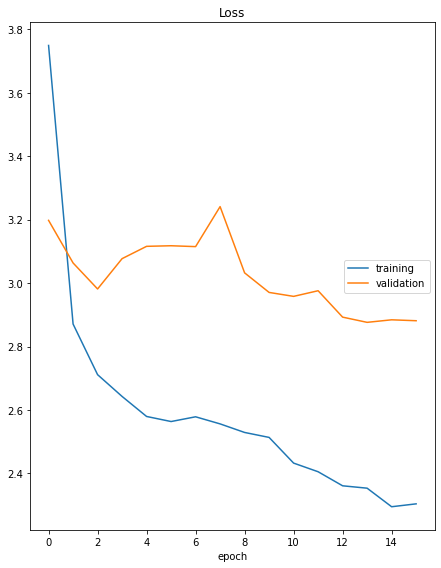

Loss
	training         	 (min:    2.295, max:    3.749, cur:    2.304)
	validation       	 (min:    2.876, max:    3.241, cur:    2.881)
Step: 0, loss: 2.413353681564331
Step: 1, loss: 2.4330203533172607
Step: 2, loss: 2.351206064224243
Step: 3, loss: 2.3386082649230957
Step: 4, loss: 2.4527840614318848
Step: 5, loss: 1.8198908567428589
Step: 6, loss: 2.1196682453155518
Step: 7, loss: 2.1131539344787598


In [ ]:
solver.training_loop(TrainDataloader, ValDataloader, 20)

In [ ]:
from google.colab import files
torch.save(solver.state_dict(), "./model.pth")
files.download("./model.pth")